In [1]:
!nvidia-smi

Tue Nov 26 23:54:56 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 556.13                 Driver Version: 556.13         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   45C    P8              9W /   30W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import json
import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from termcolor import colored
import textwrap


from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5TokenizerFast as T5Tokenizer
)
from tqdm.auto import tqdm

C:\Users\Baha Tegar\Desktop\Preparation\Transformers\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import seaborn as sns
# from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
# rcParams['figure.figsize'] = 16, 10

In [4]:
pl.seed_everything(42)

Seed set to 42


42

In [5]:
df = pd.read_csv('dataset/news_summary.csv', encoding='latin-1')
df.head()

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS...,http://www.hindustantimes.com/patna/bihar-igim...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before be...,http://indiatoday.intoday.in/story/abu-dujana-...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of s...,http://indiatoday.intoday.in/story/sex-traffic...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [6]:
df = df[['text', 'ctext']]
df.head()

,text,ctext
0,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [7]:
df.columns = ['summary', 'text']
df = df.dropna()
df.head()

,summary,text
0,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [8]:
df.shape

(4396, 2)

In [9]:
train_df, test_df = train_test_split(df, test_size=0.1)
train_df.shape, test_df.shape

((3956, 2), (440, 2))

In [10]:
class NewsSummaryDataset(Dataset):

  def __init__(
      self,
      data: pd.DataFrame,
      tokenizer: T5Tokenizer,
      text_max_token_len: int = 512,
      summary_max_token_len: int = 128,
      ):

    self.tokenizer = tokenizer
    self.data = data
    self.text_max_token_len = text_max_token_len
    self.summary_max_token_len = summary_max_token_len

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]

    text = data_row['text']

    text_encoding = tokenizer(
        text,
        max_length=self.text_max_token_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors='pt'
    )

    summary_encoding = tokenizer(
        data_row['summary'],
        max_length=self.text_max_token_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors='pt'
    )
    labels = summary_encoding['input_ids']
    # Replace padding zero with -100
    labels[labels == 0] = -100

    return dict(
        text=text,
        summary=data_row['summary'],
        text_input_ids=text_encoding['input_ids'].flatten(),
        text_attention_mask=text_encoding['attention_mask'].flatten(),
        labels=labels.flatten(),
        labels_attention_mask=summary_encoding['attention_mask'].flatten()
    )


In [11]:
class NewsSummaryDataModule(pl.LightningDataModule):

  def __init__(
      self,
      train_df: pd.DataFrame,
      test_df: pd.DataFrame,
      tokenizer: T5Tokenizer,
      batch_size: int = 8,
      text_max_token_len: int = 512,
      summary_max_token_len: int = 128
  ):

    super().__init__()

    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.batch_size = batch_size
    self.text_max_token_len = text_max_token_len
    self.summary_max_token_len = summary_max_token_len

  def setup(self, stage=None):
    self.train_dataset = NewsSummaryDataset(
        self.train_df,
        self.tokenizer,
        self.text_max_token_len,
        self.summary_max_token_len
    )

    self.test_dataset = NewsSummaryDataset(
        self.test_df,
        self.tokenizer,
        self.text_max_token_len,
        self.summary_max_token_len
    )

  def train_dataloader(self):
    return DataLoader(
        self.train_dataset,
        batch_size=self.batch_size,
        shuffle=True,
        # num_workers=2
    )

  def val_dataloader(self):
    return DataLoader(
        self.test_dataset,
        batch_size=self.batch_size,
        shuffle=False,
        # num_workers=2
    )

  def test_dataloader(self):
    return DataLoader(
        self.test_dataset,
        batch_size=self.batch_size,
        shuffle=False,
        # num_workers=2
    )



In [12]:
MODEL_NAME = "t5-base"

tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

In [13]:
text_token_counts, summary_token_counts = [], []

for idx, row in tqdm(df.iterrows(), total=len(df)):
  text_token_count = len(tokenizer.encode(row['text']))
  text_token_counts.append(text_token_count)

  summary_token_count = len(tokenizer.encode(row['summary']))
  summary_token_counts.append(summary_token_count)

100%|█████████████████████████████████████████████████████████████████████████████| 4396/4396 [00:16<00:00, 269.67it/s]


Text(0.5, 1.0, 'summary token counts')

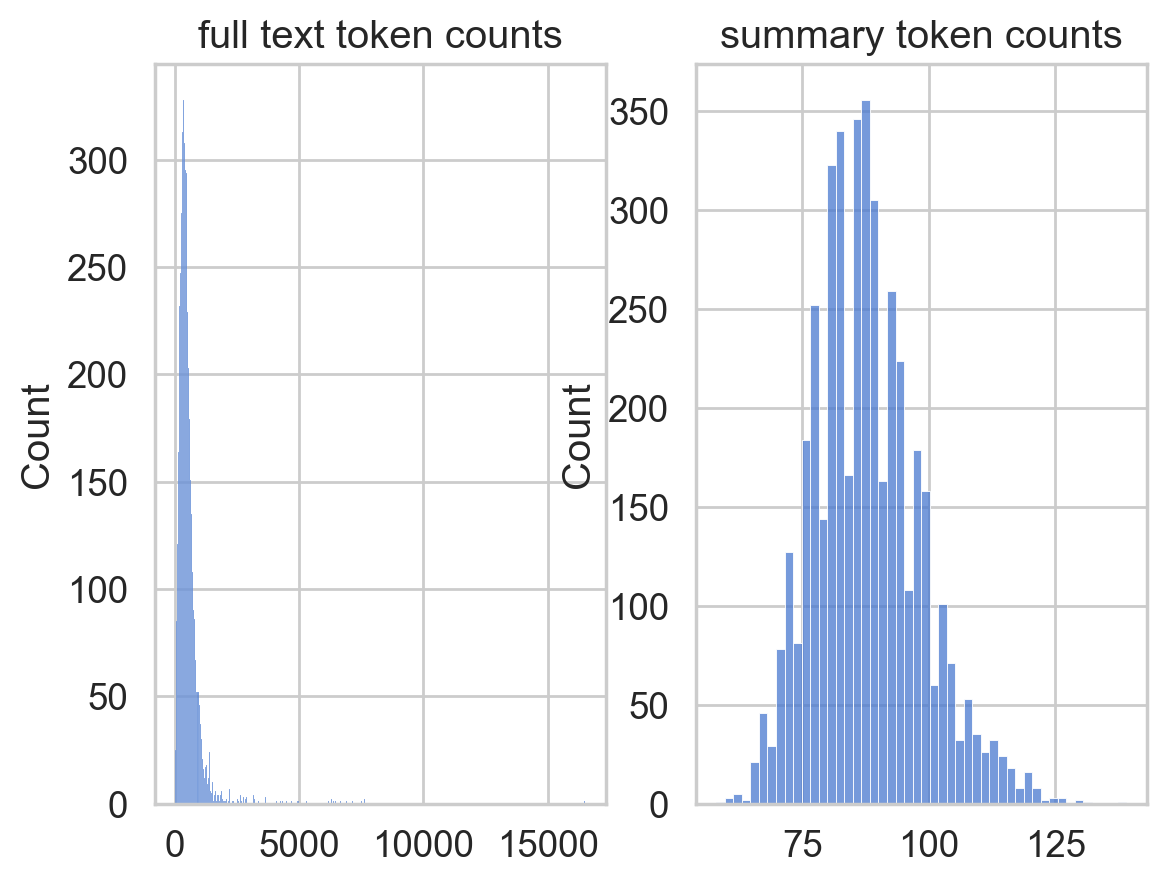

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2)

sns.histplot(text_token_counts, ax=ax1)
ax1.set_title("full text token counts")

sns.histplot(summary_token_counts, ax=ax2)
ax2.set_title("summary token counts")

In [23]:
# N_EPOCHS = 3
N_EPOCHS = 1
BATCH_SIZE = 8

data_module = NewsSummaryDataModule(train_df, test_df, tokenizer, batch_size=BATCH_SIZE)

# Model

In [24]:
class NewsSummaryModel(pl.LightningModule):
  def __init__(self):
    super().__init__()
    self.model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict=True)


  def forward(self, input_ids, attention_mask, decoder_attention_mask, labels=None):
    output = self.model(
        input_ids,
        attention_mask=attention_mask,
        labels=labels,
        decoder_attention_mask=decoder_attention_mask
    )
    return output.loss, output.logits

  def training_step(self, batch, batch_idx):
    # torch.set_grad_enabled(True)
    # assert torch.is_grad_enabled()
    input_ids = batch['text_input_ids']
    attention_mask = batch['text_attention_mask']
    labels = batch['labels']
    labels_attention_mask = batch['labels_attention_mask']

    loss, outputs = self(
        input_ids=input_ids,
        attention_mask=attention_mask,
        decoder_attention_mask=labels_attention_mask,
        labels=labels,

    )

    self.log("train_loss", loss, prog_bar=True, logger=True)
    return loss

  def validation_step(self, batch, batch_idx):
    input_ids = batch['text_input_ids']
    attention_mask = batch['text_attention_mask']
    labels = batch['labels']
    labels_attention_mask = batch['labels_attention_mask']

    loss, outputs = self(
        input_ids=input_ids,
        attention_mask=attention_mask,
        decoder_attention_mask=labels_attention_mask,
        labels=labels
    )

    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, batch_idx):
    input_ids = batch['text_input_ids']
    attention_mask = batch['text_attention_mask']
    labels = batch['labels']
    labels_attention_mask = batch['labels_attention_mask']

    loss, outputs = self(
        input_ids=input_ids,
        attention_mask=attention_mask,
        decoder_attention_mask=labels_attention_mask,
        labels=labels
    )


    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  def configure_optimizers(self):
    return AdamW(self.parameters(), lr=0.0001)


In [25]:
model = NewsSummaryModel()

In [26]:
%load_ext tensorboard
%tensorboard --logdir ./ligtning-logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

In [27]:
checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints',
    filename='best-checkpoint',
    save_top_k=1,
    verbose=True,
    monitor='val_loss',
    mode='min'
)

logger = TensorBoardLogger('ligtning-logs', name='news-summary')

trainer = pl.Trainer(
    logger=logger,
    # checkpoint_callback=checkpoint_callback,
    callbacks=[checkpoint_callback],
    max_epochs=N_EPOCHS,
    accelerator='gpu',  # Use GPU as accelerator
    devices=1,           # Use one GPU
    # gpus=1,
    # progress_bar_refresh_rate=30
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [30]:
torch.cuda.empty_cache()

In [32]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 4.00 GiB of which 0 bytes is free. Of the allocated memory 10.50 GiB is allocated by PyTorch, and 94.59 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
trained_model = NewsSummaryModel.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path
)

trained_model.freeze()

In [ ]:
def summarize(text):
    text_encoding = tokenizer(
        text,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors='pt'
    )
    
    generated_ids = trained_model.model.generate(
        input_ids=text_encoding['input_ids'],
        attention_mask=text_encoding['attention_mask'],
        max_length=150,
        num_beams=2,
        repetition_penalty=2.5,
        length_penalty=1.0,
        early_stopping=True,
    )

    preds = [
        tokenizer.decode(gen_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
        for gen_id in generated_ids
    ]

    return "".join(preds)

In [ ]:
sample_row = test_df.iloc[0]
text = sample_row['text']
model_summary = summarize(text)

In [ ]:
sample_row['summary']

In [ ]:
model_summary